In [1]:
!pip install geocoder
!pip install folium

     |████████████████████████████████| 102kB 6.9MB/s ta 0:00:011
     |████████████████████████████████| 92kB 7.1MB/s eta 0:00:011


Importing Libaries

In [2]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("Libraries Imported Successfully!")

Libraries Imported Successfully!


 Data Preprocessing

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data, 'lxml')

In [4]:
column_names = ['Postalcode','Borough','Neighborhood']
NorthYork = pd.DataFrame(columns = column_names)

content = wiki_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    NorthYork = NorthYork.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

In [5]:
# clean dataframe 
NorthYork = NorthYork[NorthYork.Borough!='Not assigned']
NorthYork = NorthYork[NorthYork.Borough!= 0]
NorthYork.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,NorthYork.shape[0]):
    if NorthYork.iloc[i][2] == 'Not assigned':
        NorthYork.iloc[i][2] = NorthYork.iloc[i][1]
        i = i+1

In [6]:
df = NorthYork.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,M1A\n,Not assigned\n,
1,M1B\n,Scarborough\n,Malvern / Rouge
2,M1C\n,Scarborough\n,Rouge Hill / Port Union / Highland Creek
3,M1E\n,Scarborough\n,Guildwood / Morningside / West Hill
4,M1G\n,Scarborough\n,Woburn


In [7]:
df.describe()

,Postalcode,Borough,Neighborhood
count,180,180,180
unique,180,11,99
top,M4R\n,Not assigned\n,
freq,1,77,77


In [8]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]

In [9]:
df.head()

,Postalcode,Borough,Neighborhood
0,M1A\n,Not assigned\n,
1,M1B\n,Scarborough\n,Malvern / Rouge
2,M1C\n,Scarborough\n,Rouge Hill / Port Union / Highland Creek
3,M1E\n,Scarborough\n,Guildwood / Morningside / West Hill
4,M1G\n,Scarborough\n,Woburn


In [10]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [11]:
df_2.describe()

,Postalcode,Borough,Neighborhood
count,180,180,180
unique,180,11,99
top,M4R\n,Not assigned\n,
freq,1,77,77


In [12]:
print(df_2.shape)
df_2.head()

(180, 3)


,Postalcode,Borough,Neighborhood
0,M1A\n,Not assigned\n,
1,M1B\n,Scarborough\n,Malvern / Rouge
2,M1C\n,Scarborough\n,Rouge Hill / Port Union / Highland Creek
3,M1E\n,Scarborough\n,Guildwood / Morningside / West Hill
4,M1G\n,Scarborough\n,Woburn


In [13]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, NorthYork, NorthYork'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M3H')

[43.75739449200006, -79.44239439999996]

In [14]:
# Retrieving Postal Code Co-ordinates
postal_codes = df_2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [15]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [16]:
df_2[df_2.Postalcode == 'M2H']

,Postalcode,Borough,Neighborhood,Latitude,Longitude


In [17]:
df_2.head(10)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1A\n,Not assigned\n,,39.98049,-76.73397
1,M1B\n,Scarborough\n,Malvern / Rouge,39.98049,-76.73397
2,M1C\n,Scarborough\n,Rouge Hill / Port Union / Highland Creek,39.98049,-76.73397
3,M1E\n,Scarborough\n,Guildwood / Morningside / West Hill,39.98049,-76.73397
4,M1G\n,Scarborough\n,Woburn,39.98049,-76.73397
5,M1H\n,Scarborough\n,Cedarbrae,39.98049,-76.73397
6,M1J\n,Scarborough\n,Scarborough Village,39.98049,-76.73397
7,M1K\n,Scarborough\n,Kennedy Park / Ionview / East Birchmount Park,39.98049,-76.73397
8,M1L\n,Scarborough\n,Golden Mile / Clairlea / Oakridge,39.98049,-76.73397
9,M1M\n,Scarborough\n,Cliffside / Cliffcrest / Scarborough Village West,39.98049,-76.73397


In [18]:
address = 'Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Seattle,Washington are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Seattle,Washington are 43.6534817, -79.3839347.


Map of NorthYork

In [19]:
map_NorthYork = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NorthYork)  
    
map_NorthYork

In [20]:
address = 'Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 43.6534817, -79.3839347.


In [21]:
# @hiddel_cell
CLIENT_ID = '4DEITP5VUB1NML42LC0IDQ1DOC5JNIQM1ZOJDO52YWKC3NBK' # my Foursquare ID
CLIENT_SECRET = 'NJP05OVK0IMPLKZHJ4DAF4MOFOEKLYWZEM1A5HM2SWY0NDAL' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4DEITP5VUB1NML42LC0IDQ1DOC5JNIQM1ZOJDO52YWKC3NBK
CLIENT_SECRET: NJP05OVK0IMPLKZHJ4DAF4MOFOEKLYWZEM1A5HM2SWY0NDAL


In [22]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [23]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.id', 'venue.location.address', 'venue.location.cc',
       'venue.location.city', 'venue.location.country',
       'venue.location.crossStreet', 'venue.location.distance',
       'venue.location.formattedAddress', 'venue.location.labeledLatLngs',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.neighborhood', 'venue.location.postalCode',
       'venue.location.state', 'venue.name', 'venue.photos.count',
       'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

In [24]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Nearby Venues/Locations

In [25]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Downtown Toronto,"[{'id': '4f2a25ac4b909258e854f55f', 'name': 'N...",43.653232,-79.385296
1,Nathan Phillips Square,"[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",43.652270,-79.383516
2,Eggspectation Bell Trinity Square,"[{'id': '4bf58dd8d48988d143941735', 'name': 'B...",43.653144,-79.381980
3,Indigo,"[{'id': '4bf58dd8d48988d114951735', 'name': 'B...",43.653515,-79.380696
4,Chatime 日出茶太,"[{'id': '52e81612bcbc57f1066b7a0c', 'name': 'B...",43.655542,-79.384684


Categories of Nearby Venues/Locations

In [26]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Nathan Phillips Square,Plaza,43.652270,-79.383516
2,Eggspectation Bell Trinity Square,Breakfast Spot,43.653144,-79.381980
3,Indigo,Bookstore,43.653515,-79.380696
4,Chatime 日出茶太,Bubble Tea Shop,43.655542,-79.384684


In [27]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Coffee Shop       10
Café               6
Clothing Store     6
Restaurant         3
Breakfast Spot     3
Gastropub          3
Hotel              3
Plaza              2
Juice Bar          2
Gym                2
Name: categories, dtype: int64

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [29]:
# Nearby Venues
NorthYork_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )


Malvern / Rouge
Rouge Hill / Port Union / Highland Creek
Guildwood / Morningside / West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park / Ionview / East Birchmount Park
Golden Mile / Clairlea / Oakridge
Cliffside / Cliffcrest / Scarborough Village West
Birch Cliff / Cliffside West
Dorset Park / Wexford Heights / Scarborough Town Centre
Wexford / Maryvale
Agincourt
Clarks Corners / Tam O'Shanter / Sullivan
Milliken / Agincourt North / Steeles East / L'Amoreaux East
Steeles West / L'Amoreaux West
Upper Rouge







Hillcrest Village
Fairview / Henry Farm / Oriole
Bayview Village
York Mills / Silver Hills
Willowdale / Newtonbrook
Willowdale
York Mills West
Willowdale







Parkwoods
Don Mills
Don Mills


Bathurst Manor / Wilson Heights / Downsview North
Northwood Park / York University
Downsview
Downsview
Downsview
Downsview









Victoria Village
Parkview Hill / Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West / Riverdale
I

In [30]:
print('There are {} Uniques Categories.'.format(len(NorthYork_venues['Venue Category'].unique())))
NorthYork_venues.groupby('Neighborhood').count().head()

There are 156 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
,2695,2695,2695,2695,2695,2695
Agincourt,35,35,35,35,35,35
Alderwood / Long Branch,35,35,35,35,35,35
Bathurst Manor / Wilson Heights / Downsview North,23,23,23,23,23,23
Bayview Village,4,4,4,4,4,4


One Hot Vector of Features

In [31]:
# one hot encoding
NorthYork_onehot = pd.get_dummies(NorthYork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NorthYork_onehot['Neighborhood'] = NorthYork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [NorthYork_onehot.columns[-1]] + list(NorthYork_onehot.columns[:-1])
NorthYork_onehot = NorthYork_onehot[fixed_columns]
NorthYork_grouped = NorthYork_onehot.groupby('Neighborhood').mean().reset_index()
NorthYork_onehot.head(5)

,Neighborhood,Airport,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Store,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Community Center,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Dentist's Office,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Donut Shop,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gastropub,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Hockey Arena,Home Service,Hotel,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Leather Goods Store,Lingerie Store,Liquor Store,Lounge,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Music Venue,Other Great Outdoors,Park,Pet Store,Pharmacy,Photography Lab,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Post Office,Pub,Ramen Restaurant,Rental Car Location,Residential Building (Apartment / Condo),Rest Area,Restaurant,Road,Rock Climbing Spot,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Soccer Field,Soccer Stadium,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taiwanese Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Wings Joint,Women's Store
0,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
num_top_venues = 5
for hood in NorthYork_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =NorthYork_grouped[NorthYork_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----  ----
                  venue  freq
0                 Hotel  0.11
1           Pizza Place  0.06
2                 Motel  0.06
3        Ice Cream Shop  0.06
4  Fast Food Restaurant  0.06


---- Agincourt ----
                  venue  freq
0                 Hotel  0.11
1           Pizza Place  0.06
2                 Motel  0.06
3        Ice Cream Shop  0.06
4  Fast Food Restaurant  0.06


---- Alderwood / Long Branch ----
                  venue  freq
0                 Hotel  0.11
1           Pizza Place  0.06
2                 Motel  0.06
3        Ice Cream Shop  0.06
4  Fast Food Restaurant  0.06


---- Bathurst Manor / Wilson Heights / Downsview North ----
            venue  freq
0            Bank  0.09
1     Coffee Shop  0.09
2   Shopping Mall  0.04
3      Restaurant  0.04
4  Sandwich Place  0.04


---- Bayview Village ----
               venue  freq
0               Park  0.50
1        Flower Shop  0.25
2              Trail  0.25
3            Airport  0.00
4  Mobile Phone Shop  

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Most Common venues near neighborhood venues

In [34]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = NorthYork_grouped['Neighborhood']

for ind in np.arange(NorthYork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NorthYork_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,,Hotel,Grocery Store,Pizza Place,Motel,Ice Cream Shop,Fast Food Restaurant,Dive Bar,Gourmet Shop,Shopping Mall,Park
1,Agincourt,Hotel,Grocery Store,Pizza Place,Motel,Ice Cream Shop,Fast Food Restaurant,Dive Bar,Gourmet Shop,Shopping Mall,Park
2,Alderwood / Long Branch,Hotel,Grocery Store,Pizza Place,Motel,Ice Cream Shop,Fast Food Restaurant,Dive Bar,Gourmet Shop,Shopping Mall,Park
3,Bathurst Manor / Wilson Heights / Downsview North,Bank,Coffee Shop,Pharmacy,Men's Store,Restaurant,Shopping Mall,Park,Bridal Shop,Middle Eastern Restaurant,Diner
4,Bayview Village,Park,Trail,Flower Shop,Department Store,Donut Shop,Flea Market,Fish Market,Fast Food Restaurant,Falafel Restaurant,Electronics Store


<h6>K-Means Clustering Approach</h6>

In [35]:
# Using K-Means to cluster neighborhood into 3 clusters
NorthYork_grouped_clustering = NorthYork_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(NorthYork_grouped_clustering)
kmeans.labels_

array([0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 2], dtype=int32)

In [36]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

NorthYork_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
NorthYork_merged = NorthYork_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

NorthYork_merged.head()# check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1A\n,Not assigned\n,,39.98049,-76.73397,0,Hotel,Grocery Store,Pizza Place,Motel,Ice Cream Shop,Fast Food Restaurant,Dive Bar,Gourmet Shop,Shopping Mall,Park
1,M1B\n,Scarborough\n,Malvern / Rouge,39.98049,-76.73397,0,Hotel,Grocery Store,Pizza Place,Motel,Ice Cream Shop,Fast Food Restaurant,Dive Bar,Gourmet Shop,Shopping Mall,Park
2,M1C\n,Scarborough\n,Rouge Hill / Port Union / Highland Creek,39.98049,-76.73397,0,Hotel,Grocery Store,Pizza Place,Motel,Ice Cream Shop,Fast Food Restaurant,Dive Bar,Gourmet Shop,Shopping Mall,Park
3,M1E\n,Scarborough\n,Guildwood / Morningside / West Hill,39.98049,-76.73397,0,Hotel,Grocery Store,Pizza Place,Motel,Ice Cream Shop,Fast Food Restaurant,Dive Bar,Gourmet Shop,Shopping Mall,Park
4,M1G\n,Scarborough\n,Woburn,39.98049,-76.73397,0,Hotel,Grocery Store,Pizza Place,Motel,Ice Cream Shop,Fast Food Restaurant,Dive Bar,Gourmet Shop,Shopping Mall,Park


Cluster Maps

In [37]:
kclusters = 8

In [38]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(NorthYork_merged['Latitude'], 
                                   NorthYork_merged['Longitude'], 
                                   NorthYork_merged['Neighborhood'], 
                                   NorthYork_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#386df9', '#12c8e6', '#5af8c8', '#a4f89f', '#ecc86f', '#ff6d38', '#ff0000']


In [39]:
df1=NorthYork_merged.loc[NorthYork_merged['Cluster Labels'] == 0,NorthYork_merged.columns[[2] + list(range(5, NorthYork_merged.shape[1]))]]
df2=NorthYork_merged.loc[NorthYork_merged['Cluster Labels'] == 1,NorthYork_merged.columns[[2] + list(range(5, NorthYork_merged.shape[1]))]]
df3=NorthYork_merged.loc[NorthYork_merged['Cluster Labels'] == 2,NorthYork_merged.columns[[2] + list(range(5, NorthYork_merged.shape[1]))]]

<h6>House rent Rating by Clusters</h6>

In [40]:
# NorthYork_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
#                                            "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
#                                                                573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
#                                                                279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
#                                                                435000.0,289500.0,265000.0,285900.0,239400.0,
#                                                                589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
#                                                                229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
#                                                                573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
#                                                                279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
#                                                                573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
#                                                                279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
#                                                                573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
#                                                                279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
#                                                                573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
#                                                                279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0]})


NorthYork_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                           "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0, 335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0]})

In [41]:
NorthYork_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)
# NorthYork_Avg_HousingPrice.set_index('Neighborhood')

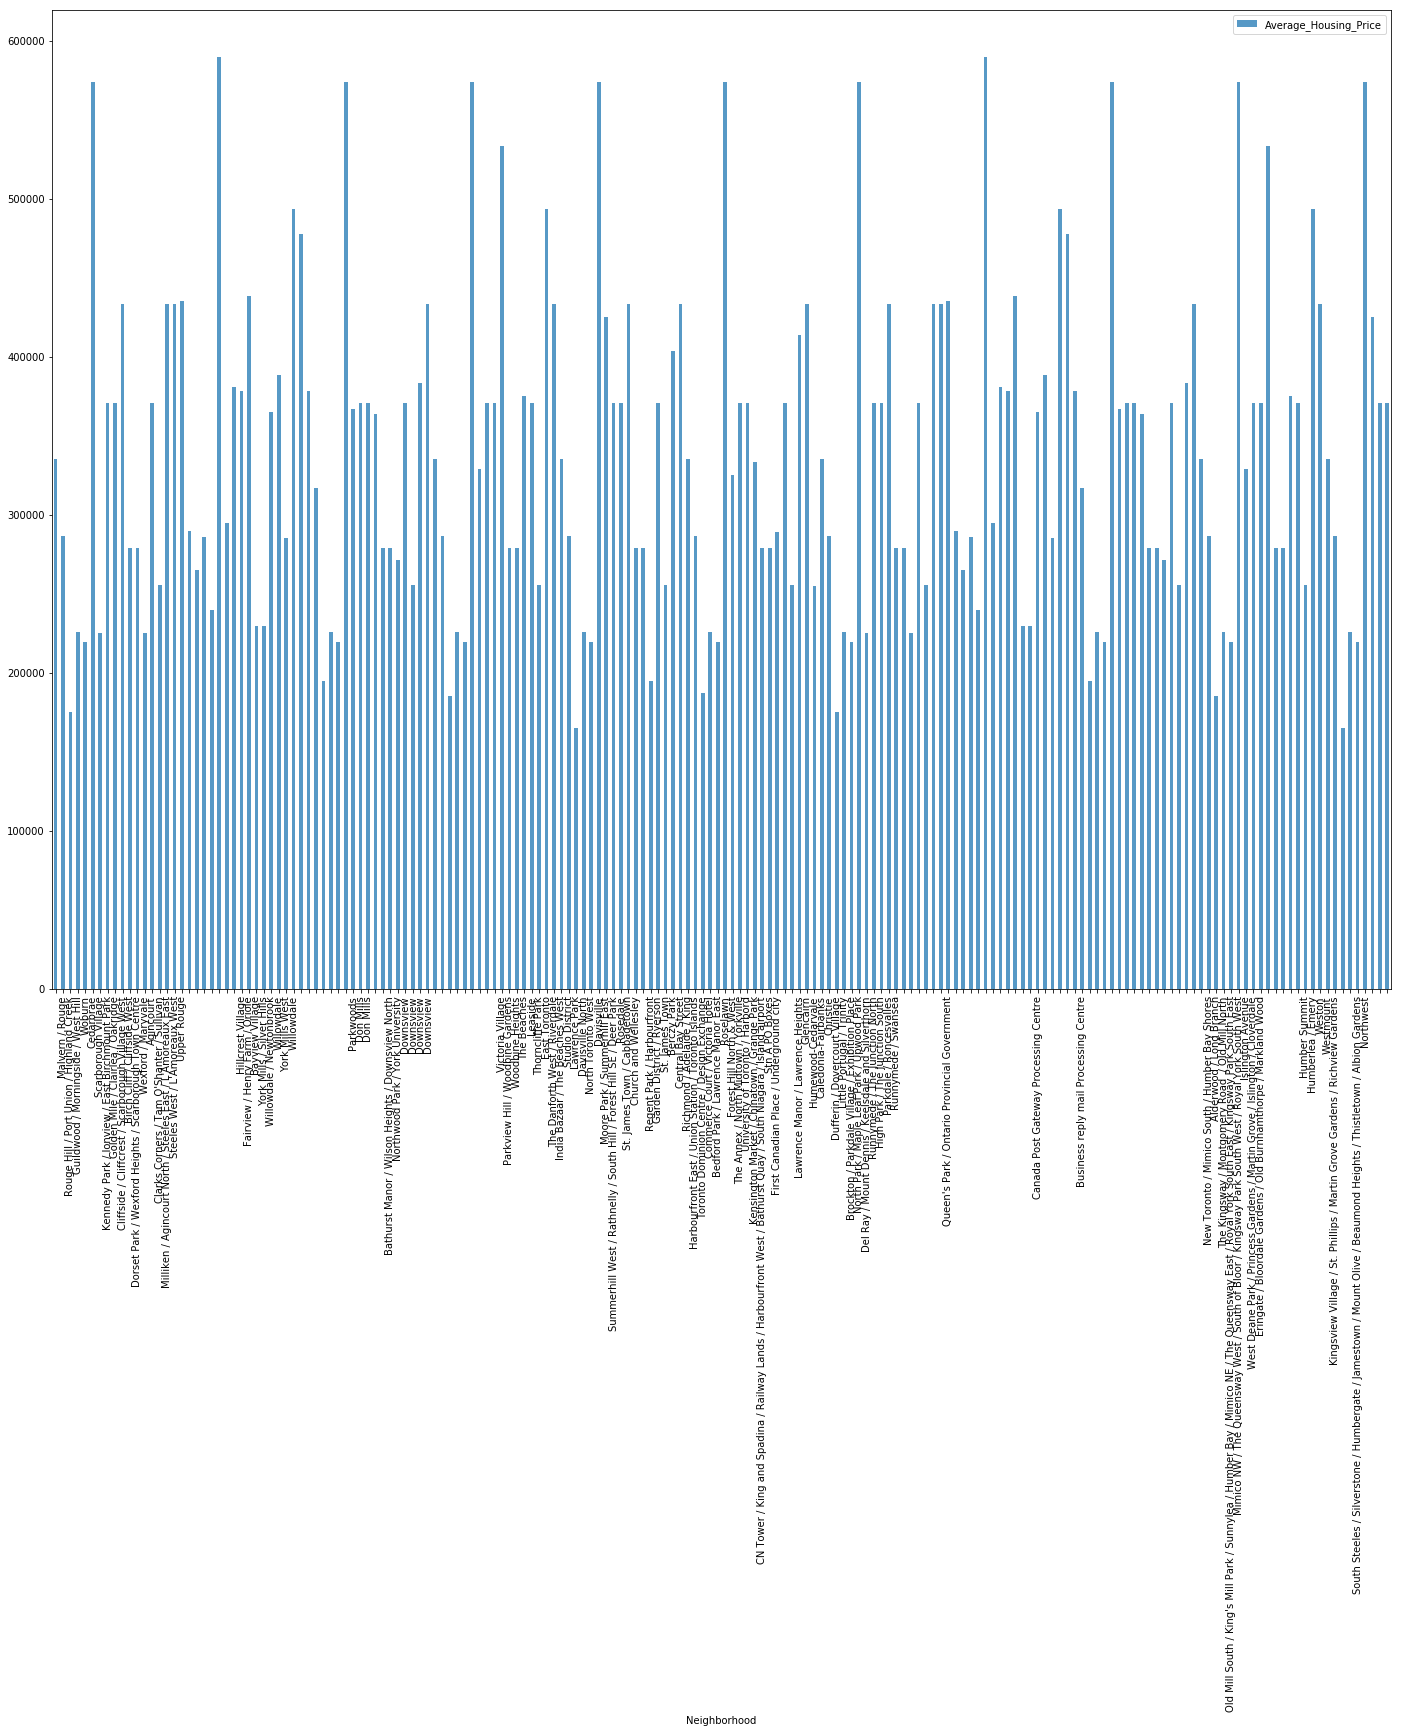

In [42]:
NorthYork_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

<h6>School Rating by Clusters</h6>

In [43]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [44]:
# new_NorthYork=NorthYork_merged.set_index("Neighborhood",drop=True)
# #Source:https://www.greatschools.org
# NorthYork_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
#                                       "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
#                                                            5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
#                                                            10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
#                                                            8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
#                                                            7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
#                                                            4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
#                                                            ]})

new_NorthYork=NorthYork_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
NorthYork_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7,
                                                           7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2]})

In [45]:
NorthYork_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

NameError: name 'plot' is not defined

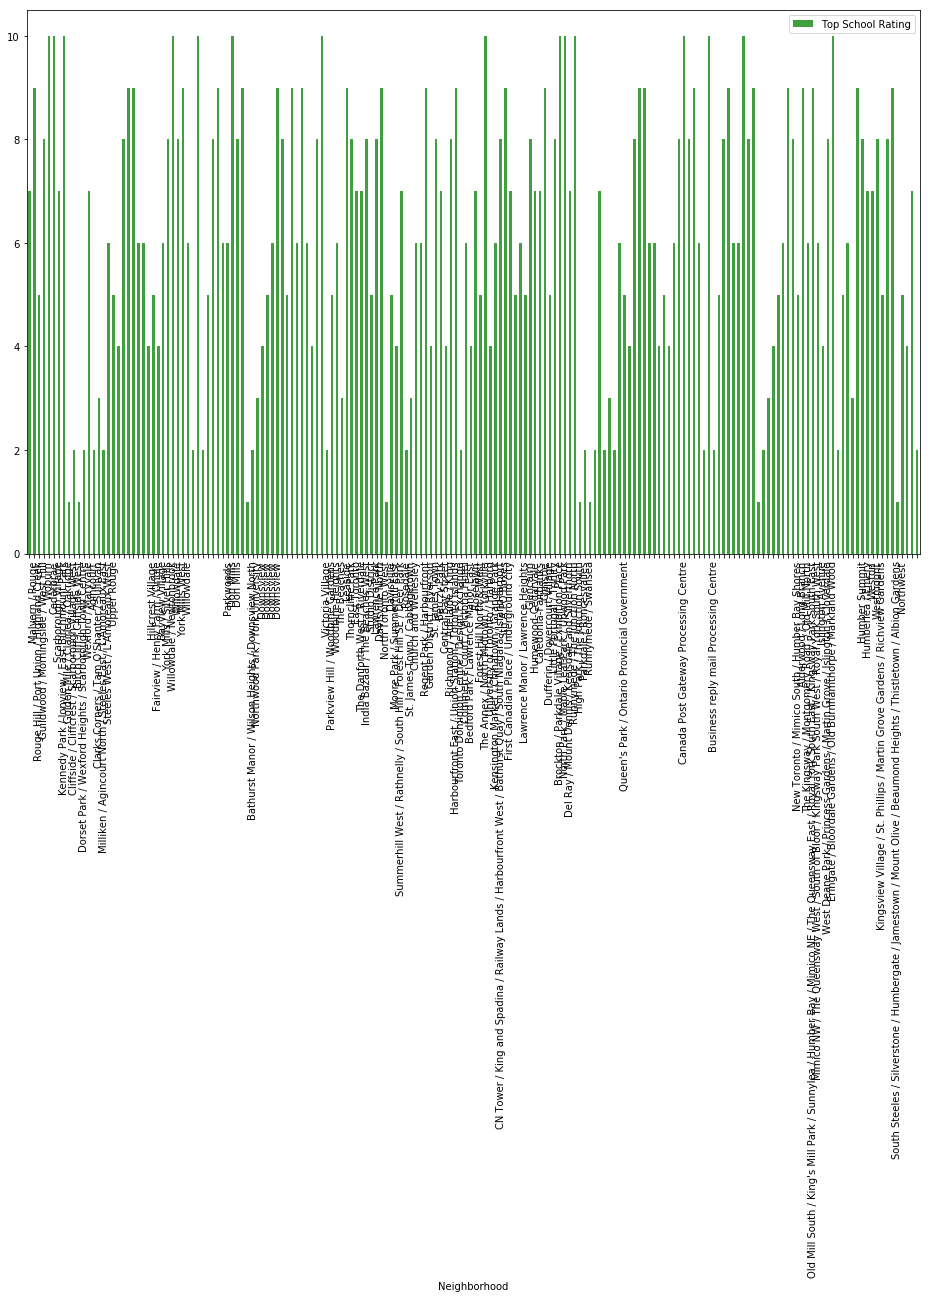

In [46]:
NorthYork_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);
plot.show()